# Merging GP regression sub-models using equivalent observations

This notebook illustrates how to use the equivalent observation framework to train an ensemble of Gaussian process models and to make predictions with it.

First, let's load some required packages

In [1]:
import numpy as np
import gpflow
from gpflow.utilities import print_summary
import guepard
from guepard.utilities import get_gpr_submodels

import matplotlib.pyplot as plt

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import HTML, display
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));

# define a couple of plotting helper functions
def plot_mean_conf(x, mean, var, ax, color='C0'):
        ax.plot(x, mean, color, lw=2)
        ax.fill_between(
            x[:, 0],
            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
            color=color,
            alpha=0.2,
        )

def plot_model(m, ax, x=np.linspace(0, 1, 101)[:, None], plot_data=True, color='C0'):
    if plot_data:
        X, Y = m.data
        ax.plot(X, Y, "kx", mew=1.)
    
    mean, var = m.predict_f(x)
    plot_mean_conf(x, mean, var, ax, color)

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


We now define a couple of helper functions, and generate a dataset

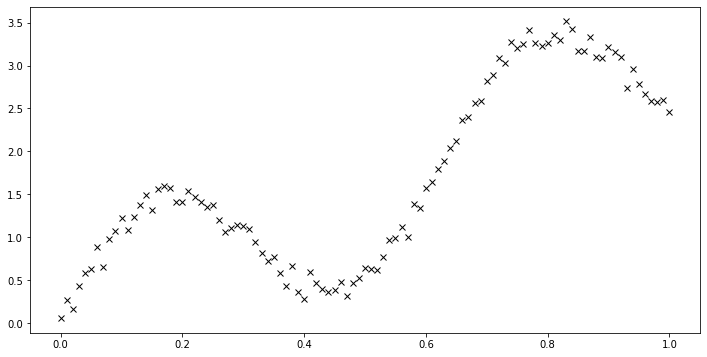

In [2]:
noise_var = 0.01

def f(x):
    return np.sin(10 * x[:, :1]) + 3. * x[:, :1]

X = np.linspace(0, 1, 101)[:, None]
#np.random.shuffle(X)
Y = f(X) + np.sqrt(noise_var) * np.random.normal(size=X.shape)

plt.plot(X, Y, 'kx')

We now split the dataset in three, and build a GPR model for each of them

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


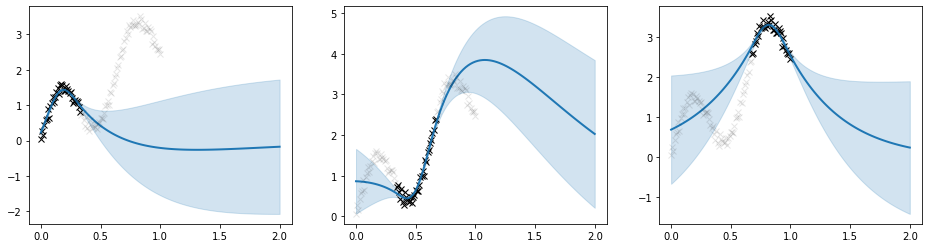

In [3]:
num_split = 3

Xl = np.array_split(X, num_split)  # list of num_split np.array
Yl = np.array_split(Y, num_split)  

kernel = gpflow.kernels.Matern32()

# make submodels and plot them
M = get_gpr_submodels(zip(Xl, Yl), kernel, noise_variance=noise_var) # list of num_split GPR models

# M is a list of GPR models, let's plot them
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
x = np.linspace(0, 2, 101)[:, None]
[plot_model(m, axes[i], x) for i, m in enumerate(M)];
[axes[i].plot(X, Y, 'kx', mew=1., alpha=.1) for i, _ in enumerate(M)];

We can now aggregate the three sub-models using PAPL

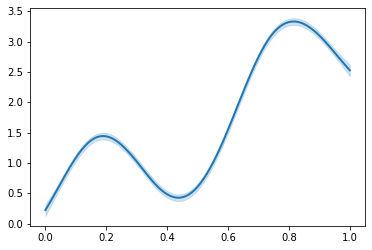

In [4]:
m_agg = guepard.EquivalentObsEnsemble(M)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_model(m_agg, ax, plot_data=False)

Guepard models inherit from `GPflow.GPmodels`, it is thus possible to interact with them like any other GPflow models:

In [5]:
# Set the value of one parameter
m_agg.kernel.lengthscales.assign(0.3)

# print the model parameter summary
gpflow.utilities.print_summary(m_agg)


╒═════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ EquivalentObsEnsemble.kernel.variance               │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
│ EquivalentObsEnsemble.models[0].kernel.variance     │           │                  │         │             │         │         │         │
│ EquivalentObsEnsemble.models[1].kernel.variance     │           │                  │         │             │         │         │         │
│ EquivalentObsEnsemble.models[2].kernel.variance     │           │                  │         │             │         │         │         │
├────────────

## Training the GPR sub-models

Guepard models can be trained like any other GPflow model

In [6]:
m_agg.training_loss()

2022-07-27 14:37:12.372024: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


<tf.Tensor: shape=(), dtype=float64, numpy=-50.054816969832736>

In [7]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_agg.training_loss, m_agg.trainable_variables, options=dict(maxiter=100))
print_summary(m_agg)

╒═════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ EquivalentObsEnsemble.kernel.variance               │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.34586 │
│ EquivalentObsEnsemble.models[0].kernel.variance     │           │                  │         │             │         │         │         │
│ EquivalentObsEnsemble.models[1].kernel.variance     │           │                  │         │             │         │         │         │
│ EquivalentObsEnsemble.models[2].kernel.variance     │           │                  │         │             │         │         │         │
├────────────

2022-07-27 14:37:13.488029: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Comparison with a GPR model based on the full dataset

In [8]:
# make a GPR model as baseline
m_gpr = gpflow.models.GPR((X, Y), kernel, noise_variance=noise_var)
opt_logs = opt.minimize(m_gpr.training_loss, m_gpr.trainable_variables, options=dict(maxiter=100))
print_summary(m_gpr)

# Check "good" match between aggregated model and gpr at training points
mean_agg, var_agg = m_agg.predict_f(X)
mean_gpr, var_gpr = m_gpr.predict_f(X)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.50941 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.59288 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.00842 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

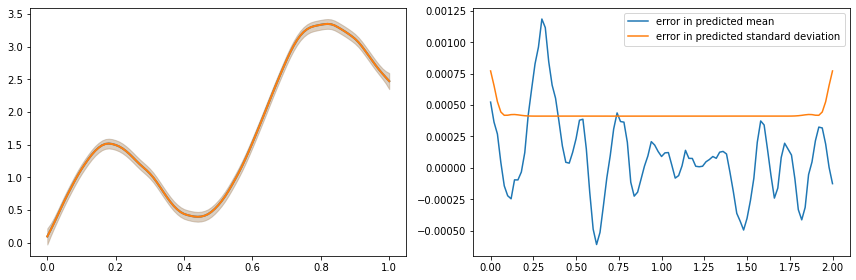

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_model(m_agg, axes[0], plot_data=False)
plot_model(m_gpr, axes[0], plot_data=False, color='C1')

axes[1].plot(x, mean_agg - mean_gpr, label="error in predicted mean")
axes[1].plot(x, np.sqrt(var_agg) - np.sqrt(var_gpr), label="error in predicted standard deviation")
plt.legend()
plt.tight_layout()

On this simple example, predictions from PAPL are extremely close to the ground truth despite requiring to store and invert matrices that are 1/3rd of the size of a full model.  

## Sampling from the posterior

Since Guepard models are classic GPflow models, we can use the build in functions

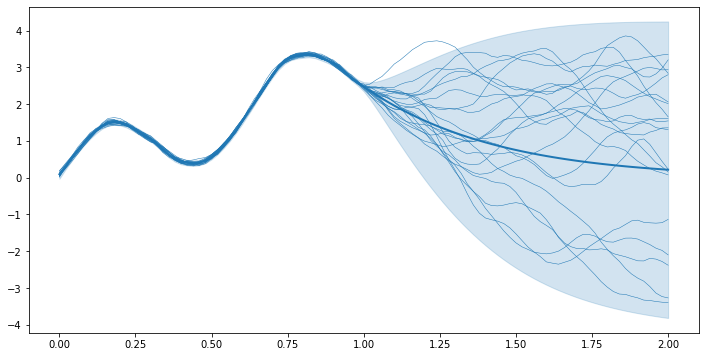

In [10]:
x = np.linspace(0, 2, 101)[:, None]
F = m_agg.predict_f_samples(x, 20).numpy()[:, :, 0]

fig, ax = plt.subplots(1, 1)
plt.plot(x, F.T, "C0", linewidth=.5);
plot_model(m_agg, ax, x, plot_data=False)

Alternatively, one can use the so-called Matheron trick to generate (approximate?) samples that are continuous functions:

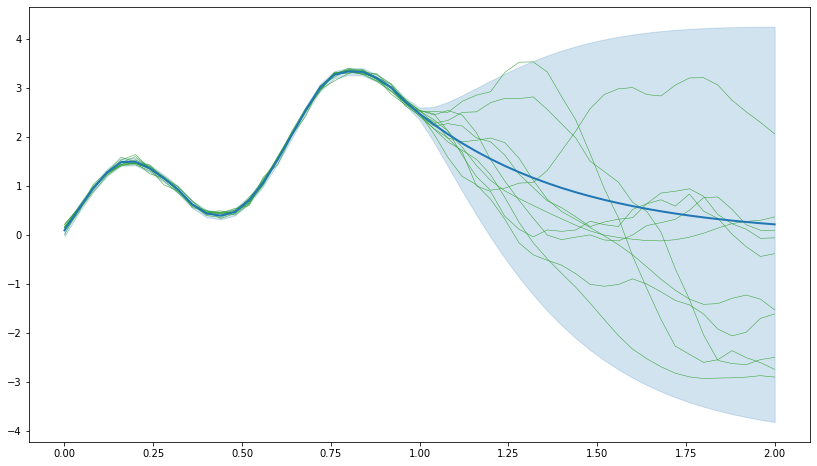

In [11]:
import tensorflow as tf
from gpflux.layers.basis_functions.fourier_features import RandomFourierFeaturesCosine

tf.keras.backend.set_floatx('float64')

class Sample:
    def __init__(self, kernel, noise_variance=0., num_rff=10000):
        self.features = RandomFourierFeaturesCosine(kernel, n_components=num_rff)
        self.random_weight = np.random.normal(0, 1, (num_rff, 1))
        self.noise_variance = noise_variance
        
    def signal(self, x):
        signal = self.features(x) @ self.random_weight
        return signal
    
    def __call__(self, x):
        noise = np.sqrt(self.noise_variance) * np.random.normal(0, 1, (x.shape[0], 1))
        return  self.signal(x) + noise


fig, ax = plt.subplots(1, 1, figsize=(14, 8))

for i in range(10):
    x = np.linspace(0, 2, 51)[:, None]
    f = Sample(kernel)
    E = Y - f(X) + np.sqrt(noise_var) * np.random.normal(size=Y.shape)
    Es = np.array_split(E, num_split)

    # build a list of submodels of the error
    Me = get_gpr_submodels(zip(Xl, Es), kernel, noise_variance=noise_var)

    # aggregate predictions
    m_agg_error = guepard.EquivalentObsEnsemble(Me)
    m, v = m_agg_error.predict_f(x)
    ax.plot(x, f(x) + m, 'C2', lw=.5)

plot_model(m_agg, ax, x, plot_data=False)